# Pipeline 1: Basic Crude pipeline

In [2]:
import sys
import os
import pandas as pd

module_path = '../'
sys.path.append(module_path)

from titansurv.preprocessing.transformers import *

In [3]:
df = pd.read_csv('../data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
dfX = df.drop('Survived', axis=1)
dfy = df.Survived

# Pipeline outline:

1. Drop Name, Ticket - requires Feature Engineering
2. OneHotEncoder for Sex, Embarked
3. Drop Cabin - requires Feature Engineering/(?And Not Imputation)
4. Impute Age with mean
5. Drop NaN rows in Embarked
6. Scaling Age and Fare


## Preprocessing_pre 
These steps include the sample size altering steps.

In [6]:
from sklearn.pipeline import Pipeline
from titansurv.utils import print_params

In [7]:
pre1 = Pipeline([
    ('nan_drpr', NaNDropper(['Embarked']))
])

dfX, dfy = pre1.fit_transform(dfX, dfy)

### Hyperparameters

In [8]:
print_params(pre1)

['memory', 'steps', 'verbose', 'nan_drpr', 'nan_drpr__key']


## Preprocessing
These include the sklearn compatible steps but can be divided into sequential and parallel steps

In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [10]:
pre2 = Pipeline([
    ('imp', SimpleImputer()),
    ('scaler', StandardScaler())
], 'passthrough')



precomb2 = ColumnTransformer([
    ('clmn_drpr', 'drop', ['Name', 'Ticket', 'Cabin']),
    ('enc', OneHotEncoder(drop='first'), ['Sex', 'Embarked']),
    ('imp_scaler', pre2, ['Age', 'Fare'])
], 'passthrough')


In [11]:
precomb2.fit_transform(dfX)

array([[1., 0., 1., ..., 3., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 3., 0., 0.],
       ...,
       [0., 0., 1., ..., 3., 1., 2.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 3., 0., 0.]])

### Hyperparameters

Note that since I didn't use ColumnDropper I can't choose which columns to drop as a parameter, but I can use modify_transformer_cols

In [12]:
print_params(precomb2)

['n_jobs',
 'remainder',
 'sparse_threshold',
 'transformer_weights',
 'transformers',
 'verbose',
 'clmn_drpr',
 'enc',
 'imp_scaler',
 'enc__categories',
 'enc__drop',
 'enc__dtype',
 'enc__handle_unknown',
 'enc__sparse',
 'imp_scaler__memory',
 'imp_scaler__steps',
 'imp_scaler__verbose',
 'imp_scaler__imp',
 'imp_scaler__scaler',
 'imp_scaler__imp__add_indicator',
 'imp_scaler__imp__copy',
 'imp_scaler__imp__fill_value',
 'imp_scaler__imp__missing_values',
 'imp_scaler__imp__strategy',
 'imp_scaler__imp__verbose',
 'imp_scaler__scaler__copy',
 'imp_scaler__scaler__with_mean',
 'imp_scaler__scaler__with_std']


## Model fitting

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [14]:
modelpipe = Pipeline([
    ('clf', KNeighborsClassifier())
])

pipe = Pipeline([
    ('preprocess', precomb2),
    ('model', modelpipe)
])

pipe.fit(dfX, dfy.values)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('clmn_drpr', 'drop',
                                                  ['Name', 'Ticket', 'Cabin']),
                                                 ('enc',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Sex', 'Embarked']),
                                                 ('imp

In [15]:
cross_val_score(pipe, dfX, dfy, cv=5).mean()

0.50069193169555

In [16]:
pipe.score(dfX, dfy)

0.7154105736782902

In [17]:
print_params(pipe)

['memory',
 'steps',
 'verbose',
 'preprocess',
 'model',
 'preprocess__n_jobs',
 'preprocess__remainder',
 'preprocess__sparse_threshold',
 'preprocess__transformer_weights',
 'preprocess__transformers',
 'preprocess__verbose',
 'preprocess__clmn_drpr',
 'preprocess__enc',
 'preprocess__imp_scaler',
 'preprocess__enc__categories',
 'preprocess__enc__drop',
 'preprocess__enc__dtype',
 'preprocess__enc__handle_unknown',
 'preprocess__enc__sparse',
 'preprocess__imp_scaler__memory',
 'preprocess__imp_scaler__steps',
 'preprocess__imp_scaler__verbose',
 'preprocess__imp_scaler__imp',
 'preprocess__imp_scaler__scaler',
 'preprocess__imp_scaler__imp__add_indicator',
 'preprocess__imp_scaler__imp__copy',
 'preprocess__imp_scaler__imp__fill_value',
 'preprocess__imp_scaler__imp__missing_values',
 'preprocess__imp_scaler__imp__strategy',
 'preprocess__imp_scaler__imp__verbose',
 'preprocess__imp_scaler__scaler__copy',
 'preprocess__imp_scaler__scaler__with_mean',
 'preprocess__imp_scaler__scal

In [18]:
param_grid = {'model__clf__n_neighbors': range(1, 11, 2), 
              'preprocess__imp_scaler__imp__strategy': ['median', 'mean']}

In [19]:
grid = GridSearchCV(pipe, param_grid)
grid.fit(dfX, dfy)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('clmn_drpr',
                                                                         'drop',
                                                                         ['Name',
                                                                          'Ticket',
                                                                          'Cabin']),
                                                                        ('enc',
                                              

In [20]:
print(grid.best_params_)
print(grid.best_score_)

{'model__clf__n_neighbors': 7, 'preprocess__imp_scaler__imp__strategy': 'median'}
0.5074335047292579


## Try various models with the default hyperparameters

In [21]:
models = [
    RidgeClassifier(),
    LogisticRegression(max_iter=-1),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    SVC(),
    RandomForestClassifier(),
    BaggingClassifier()
]

param_grid = {
    'model__clf': models}

In [22]:
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(dfX, dfy);

/home/abhi/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/abhi/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

In [23]:
print(grid.best_params_)
print(grid.best_score_)

{'model__clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)}
0.7941915825557037


So I can get \~80% accuracy by no hyperparameter tuning in the pipeline by using the RandomForestClassifier. Nice! :D <br/>

<font color='red'>DOUBT</font>: Do I need to separately see the OOB accuracy for RandomForest?

In [24]:
import seaborn as sns

In [25]:
res = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__clf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.111702,0.011513,0.014274,0.004182,"RandomForestClassifier(bootstrap=True, ccp_alp...",{'model__clf': RandomForestClassifier(bootstra...,0.679775,0.797753,0.853933,0.808989,0.830508,0.794192,0.060350,1
0,0.021548,0.021777,0.004272,0.000720,"RidgeClassifier(alpha=1.0, class_weight=None, ...","{'model__clf': RidgeClassifier(alpha=1.0, clas...",0.792135,0.814607,0.780899,0.764045,0.807910,0.791919,0.018270,2
1,0.030437,0.001035,0.004126,0.000292,"LogisticRegression(C=1.0, class_weight=None, d...","{'model__clf': LogisticRegression(C=1.0, class...",0.764045,0.775281,0.775281,0.769663,0.796610,0.776176,0.011034,3
6,0.022957,0.000473,0.004990,0.000315,"BaggingClassifier(base_estimator=None, bootstr...",{'model__clf': BaggingClassifier(base_estimato...,0.601124,0.825843,0.825843,0.792135,0.830508,0.775090,0.088066,4
3,0.012124,0.000195,0.004406,0.000364,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",{'model__clf': DecisionTreeClassifier(ccp_alph...,0.573034,0.786517,0.786517,0.775281,0.841808,0.752631,0.092755,5


In [27]:
from titansurv.plotting import plot_grid_results

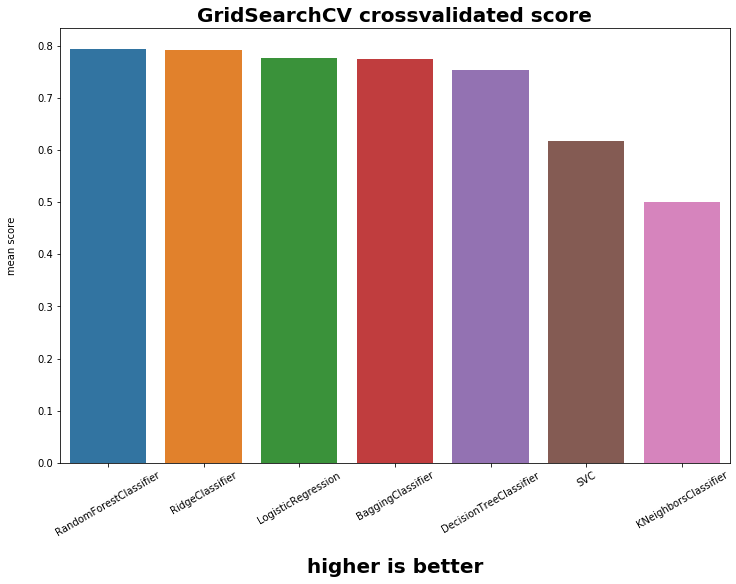

In [28]:
plot_grid_results(grid, 'model__clf', 'score');

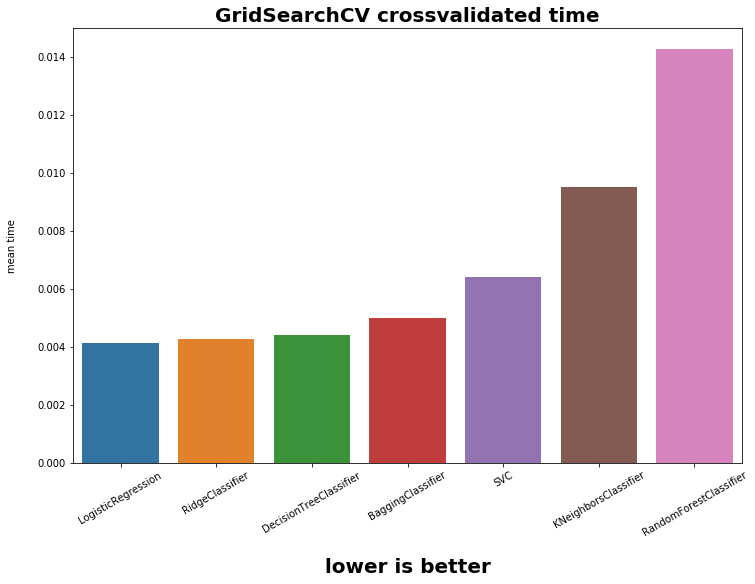

In [29]:
plot_grid_results(grid, 'model__clf', 'time');

Here is how I think performing the initial no tuning pipeline with different ML models could help:

1. Examine top n models with the best score and the best time
2. Discard absolute worst ML models

## Deciding the hyperparameters

In [30]:
param_dict = {} 

### Logistic Regression

    penalty : str, 'l1', 'l2', 'elasticnet' or 'none', optional (default='l2')
        Used to specify the norm used in the penalization. The 'newton-cg',
        'sag' and 'lbfgs' solvers support only l2 penalties. 'elasticnet' is
        only supported by the 'saga' solver. If 'none' (not supported by the
        liblinear solver), no regularization is applied.

In [32]:
# solvers = ['newton-cg', 'lbfgs', 'liblinear'] # Solver and penalty incompatibility (read doc)
penalty = ['l2']
solvers = ['newton-cg', 'sag', 'lbfgs']
max_iter = [200]

C = [100, 10, 1, 0.1, 0.01]

param_dict['LogisticRegression'] = {
    'model__clf': [LogisticRegression(max_iter=-1)],
    'model__clf__solver' : solvers,
    'model__clf__penalty': penalty,
    'model__clf__C': C
    
}


### Support Vector Classification

In [33]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = [0.1, 1, 10, 100, 'scale']

param_dict['SVC'] = {
    'model__clf': [SVC()],
    'model__clf__C': C,
    'model__clf__gamma': gamma
}

### RandomForest

In [34]:
max_features = ['sqrt', 'log2']
n_estimators = [10, 100, 1000]
min_samples_split = [2, 5, 10, 20]
max_depth = [None, 5, 10, 25, 50, 100]
min_samples_leaf = [1, 2, 5, 10]

param_dict['RandomForestClassifier'] = {
    'model__clf': [RandomForestClassifier()],
    'model__clf__max_features': max_features,
    'model__clf__n_estimators': n_estimators,
    'model__clf__min_samples_split': min_samples_split,
    'model__clf__max_depth': max_depth,
    'model__clf__min_samples_leaf': min_samples_leaf
}

In [35]:
param_grid = list(param_dict.values())
param_grid

[{'model__clf': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False)],
  'model__clf__solver': ['newton-cg', 'sag', 'lbfgs'],
  'model__clf__penalty': ['l2'],
  'model__clf__C': [100, 10, 1, 0.1, 0.01]},
 {'model__clf': [SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
       decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
       max_iter=-1, probability=False, random_state=None, shrinking=True,
       tol=0.001, verbose=False)],
  'model__clf__C': [50, 10, 1.0, 0.1, 0.01],
  'model__clf__gamma': [0.1, 1, 10, 100, 'scale']},
 {'model__clf': [RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', m

In [209]:
grid = GridSearchCV(pipe, param_grid)
grid.fit(dfX, dfy);

/home/abhi/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/abhi/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

/home/abhi/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/abhi/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

In [210]:
print(grid.best_params_)
print(grid.best_score_)

{'model__clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'model__clf__max_depth': 100, 'model__clf__max_features': 'log2', 'model__clf__min_samples_leaf': 5, 'model__clf__min_samples_split': 2, 'model__clf__n_estimators': 1000}
0.8335428172411605
